In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain, detrend_members
from exp_hp import get_hp

2024-08-30 14:38:57.031893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:38:57.314194: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


### Load standardized E3SM

In [3]:
%%time
EXP_NAME = 'exp2'
EXP_NAME2 = 'exp2_retrain'
hps = get_hp(EXP_NAME)
hps2 = get_hp(EXP_NAME2)

print('Training Members: '+str(hps2['train_mems']))
print('Validation Member: '+str(hps2['val_mems'][0]))
print('Testing Member: '+str(hps2['test_mems'][0]))
print('Lead: '+str(hps2['LEAD']))
print('Region: '+str(hps2['region'][0])+'N x '+str(hps2['region'][1])+'E')

_, _, X1test, _, _, Y1test,inew = split_retrain(trainmems = hps2['train_mems'],
                                                  valmem = hps2['val_mems'][0],
                                                  testmem = hps2['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps2['LEAD'])

X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))

#----- SET UP & TRAIN NN -----
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving
CPU times: user 13.7 s, sys: 2.9 s, total: 16.6 s
Wall time: 28.2 s


0
240/240 [==============================] - 0s 803us/step
1
240/240 [==============================] - 0s 896us/step
2
240/240 [==============================] - 0s 1ms/step
3
240/240 [==============================] - 0s 921us/step
4
240/240 [==============================] - 0s 824us/step
5
240/240 [==============================] - 0s 909us/step
6
240/240 [==============================] - 0s 853us/step
7
240/240 [==============================] - 0s 880us/step
8
240/240 [==============================] - 0s 795us/step
9
240/240 [==============================] - 0s 801us/step


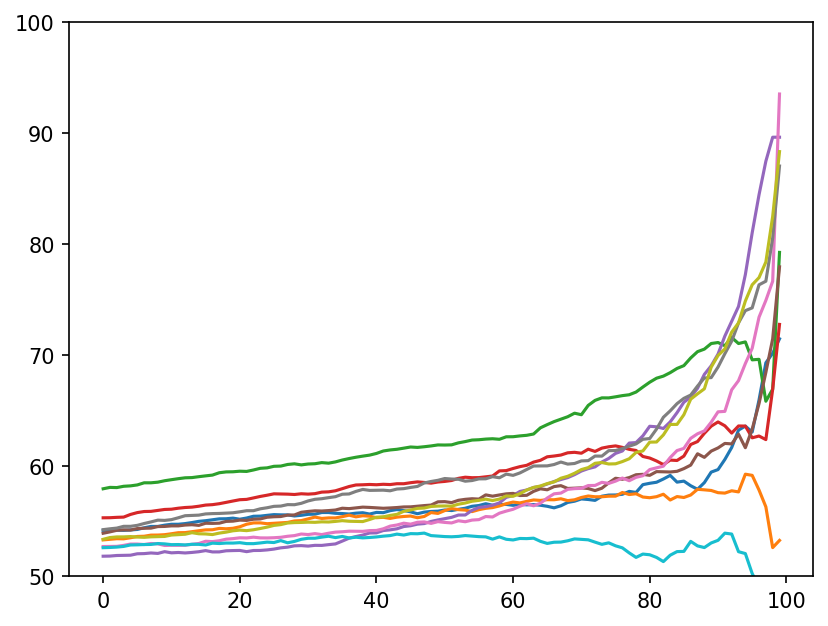

In [7]:
acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann2_60Eshift_check_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

    pred = ann.predict(X1test)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))
        icorr = np.where(predval[iconf] == Y1test[iconf])

        acc.append((len(icorr[0])/len(iconf[0]))*100)
    plt.plot(acc)
    plt.ylim(50,100)

    acc_all.append(acc)
plt.show()
# np.save(base_dir+'test/confvsacc/confvsacc_ann2_60Eshift_'+EXP_NAME2+'.8_ann1-'+EXP_NAME+'.npy', acc_all, allow_pickle=True)

In [17]:
# get SST data:
path = '/glade/campaign/cgd/amp/jcaron/ongoing_projects/cvdp-le/output/final_cesm_e3sm_future_nonprime/1920-2100/'
ens = ['0101','0111','0121','0131','0141','0151','0161','0171','0181','0191',
       '0201','0211','0221','0231','0241','0251','0261','0271','0281','0291',
       '0301']

for e in range(len(ens)):
    finame = 'E3SM2_'+ens[e]+'.cvdp_data.1920-2100.nc'
    if e == 0:
        nino34 = xr.open_dataset(path+finame,decode_times=False)['nino34']
    elif e > 0:
        temp_nino34 = xr.open_dataset(path+finame,decode_times=False)['nino34']
        nino34 = xr.concat([nino34,temp_nino34],dim='ens')

newtime = pd.date_range("1920-01-01", freq="MS", periods=len(nino34.time))
nino34['time'] = newtime                           
nino34 = nino34.where((nino34.time.dt.year >= 1950) & (nino34.time.dt.year <= 2015), drop = True)

nino34_ensmean = nino34.mean('ens')

nino34_detrended = detrend_members(data = nino34, 
                                   ensmean_data = nino34_ensmean, 
                                   npoly=3)

nino34_detrended_upsample = nino34_detrended.resample(time='1D').asfreq()
nino34_detrended_upsample = nino34_detrended_upsample.where(~((nino34_detrended_upsample.time.dt.month == 2) & (nino34_detrended_upsample.time.dt.day == 29)),drop=True)
nino34_detrended_upsample = nino34_detrended_upsample.ffill(dim='time')
nino34_detrended_upsample = nino34_detrended_upsample[:,6:-335] # 6: account for days 1-6 missing in X because of rolling mean; 
                                                                #-355: had to go through 2015 (not 2014) to get all days in Dec 2014 (not just 12-01-2014)

# nino34_detrended[0].plot()
# nino34_detrended_upsample[0].plot()

nino34_test = nino34_detrended_upsample[np.where(np.asarray(ens) == hps['test_mems'][0])[0][0],:-6][:-hps['LEAD']]
nino34_test_NDJF = nino34_test[nino34_test.time.dt.month.isin([11,12,1,2])]
nino34test = nino34_test_NDJF.isel(time = inew,drop=True)

In [18]:
q = 80
iENSO = (nino34test > 1) | (nino34test < -1)
ensoconf_frac = []

for SEED in range(10):
    print(SEED)
    annfi_name = 'ann2_60Eshift_'+EXP_NAME2+'.8_ann1-'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)
    
    pred = ann.predict(X1test)
    predconf = np.max(pred,axis=-1)
    iconf = predconf >= np.percentile(predconf,q=q)
    
    # fraction of confident predictions during ENSO:
    iconfENSO = iENSO & iconf

    ensoconf_frac.append(np.shape(pred[iconfENSO])[0]/np.shape(pred[iconf])[0])
    print(np.shape(pred[iconfENSO])[0]/np.shape(pred[iconf])[0])
    
    # fraction of ENSO days
    print(np.shape(pred[iENSO])[0]/np.shape(pred)[0])

print(np.mean(ensoconf_frac))

0
240/240 [==============================] - 0s 696us/step
0.80859375
0.440625
1
240/240 [==============================] - 0s 679us/step
0.7936197916666666
0.440625
2
240/240 [==============================] - 0s 863us/step
0.79296875
0.440625
3
240/240 [==============================] - 0s 694us/step
0.810546875
0.440625
4
240/240 [==============================] - 0s 858us/step
0.7955729166666666
0.440625
5
240/240 [==============================] - 0s 685us/step
0.794921875
0.440625
6
240/240 [==============================] - 0s 702us/step
0.794921875
0.440625
7
240/240 [==============================] - 0s 695us/step
0.787109375
0.440625
8
240/240 [==============================] - 0s 1ms/step
0.7819010416666666
0.440625
9
240/240 [==============================] - 0s 850us/step
0.7884114583333334
0.440625
0.7948567708333333
